### CODE 1

In [1]:
import os, ast, json
import pandas as pd

# --- 1) Point to your file ---
#PATH = r"C:\Users\nadia\Downloads\AI4Science_Dataset.txt"

# NOTE: Dataset is not included in the repo due to size.
# Please update this path to where AI4Science_Dataset.txt is stored locally.
PATH = Path("AI4Science_Dataset.txt")

if not PATH.exists():
    print("⚠️ The dataset file is not found. Please place AI4Science_Dataset.txt in this folder.")

if not os.path.exists(PATH):
    raise FileNotFoundError(f"File not found at: {PATH}")

# --- 2) Robust read: auto-detect delimiter, handle weird lines ---
def smart_read(path):
    # Try pandas' sniffer first
    try:
        return pd.read_csv(path, sep=None, engine="python", on_bad_lines="skip", encoding="utf-8")
    except Exception:
        pass
    # Try common fallbacks
    for sep in ["\t", ",", "|", ";", "~"]:
        try:
            return pd.read_csv(path, sep=sep, engine="python", on_bad_lines="skip", encoding="utf-8")
        except Exception:
            continue
    raise ValueError("Could not parse the file with common delimiters. Open the first few lines to see the delimiter.")

df = smart_read(PATH)
print("Loaded shape:", df.shape)
print("Columns:", list(df.columns)[:20])
print(df.head(3))


Loaded shape: (162656, 10)
Columns: ['pmid', 'title', 'abstract', 'mesh', 'year', 'source', 'index', 'Is_AI4Sci', 'extraction', 'cluster_labels']
         pmid                                              title  \
0  25552561.0  Giant ankyrin-G stabilizes somatodendritic GAB...   
1  25552560.0  Protein design algorithms predict viable resis...   
2  25552559.0  Trigger loop folding determines transcription ...   

                                            abstract  \
0  GABAA-receptor-based interneuron circuitry is ...   
1  Methods to accurately predict potential drug t...   
2  Two components of the RNA polymerase (RNAP) ca...   

                                                mesh    year  \
0  {'D000818': {'descriptor_name': 'Animals', 'ma...  2015.0   
1  {'D000465': {'descriptor_name': 'Algorithms', ...  2015.0   
2  {'D012321': {'descriptor_name': 'DNA-Directed ...  2015.0   

                     source  index Is_AI4Sci  \
0  Proc Natl Acad Sci U S A    0.0     False   
1  

### CODE 2:

In [2]:
import ast, json

def parse_extraction(s):
    """Parse the extraction column safely (JSON or dict)."""
    if not isinstance(s, str):
        return {}
    s = s.strip()
    if not s:
        return {}
    try:
        return json.loads(s)
    except Exception:
        try:
            return ast.literal_eval(s)
        except Exception:
            return {}

def get_discipline_from_extraction(s):
    obj = parse_extraction(s)
    if not isinstance(obj, dict):
        return None
    # Check common keys used in this dataset
    for key in obj.keys():
        if "discipline" in key.lower():
            return obj[key]
    # If not direct, try nested dicts
    for v in obj.values():
        if isinstance(v, dict):
            for subk, subv in v.items():
                if "discipline" in subk.lower():
                    return subv
    return None

df["discipline"] = df["extraction"].apply(get_discipline_from_extraction)

print("✅ Unique disciplines found:")
print(pd.Series(df["discipline"].dropna().unique())[:50])


✅ Unique disciplines found:
0                                Neuroscience
1                 Biochemistry / Microbiology
2                           Molecular Biology
3                            Traffic Dynamics
4                   Physics/Materials Science
5                   Microbiology/Parasitology
6                               Endocrinology
7                     Microbiology/Biophysics
8            Microbiology / Molecular Biology
9                        Microbiology/Ecology
10                       Neuroscience/Biology
11                      Immunology/Metabolism
12                                 Immunology
13              Biomedical Sciences/Nutrition
14                            Biology/Ecology
15                              Plant Biology
16                  Psychology / Neuroscience
17                                    Ecology
18             Biochemistry/Molecular Biology
19                      Environmental Science
20                  Geophysics/Earth Sciences
21    

### CODE 3:

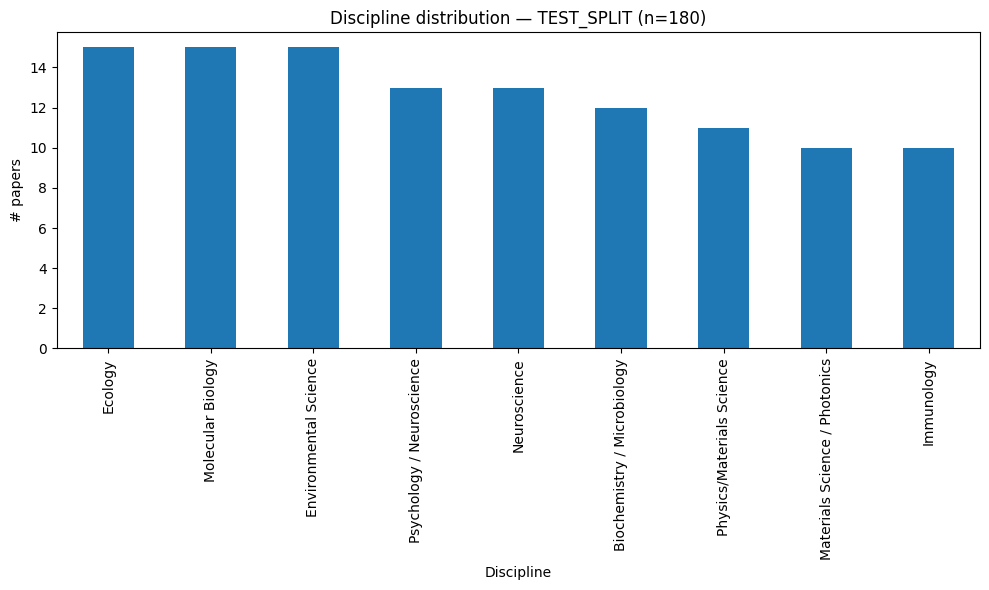

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

#BASE = Path(r"C:\Users\nadia\Downloads\llm_causality_eval")

BASE = Path("llm_causality_eval")  # relative path inside repo

if not BASE.exists():
    print("⚠️ Folder 'llm_causality_eval' not found. Make sure you're running the notebook from the project directory.")

test = pd.read_excel(BASE/"TEST_SPLIT.xlsx", engine="openpyxl")

ax = (test["discipline"]
      .astype(str)
      .value_counts()
      .sort_values(ascending=False)
      .plot(kind="bar", figsize=(10,6)))
ax.set_title("Discipline distribution — TEST_SPLIT (n=180)")
ax.set_xlabel("Discipline")
ax.set_ylabel("# papers")
plt.tight_layout()
plt.show()

# If you're using the merged eval df you showed, use discipline_true:
# ax = (df["discipline_true"].astype(str).value_counts().plot(kind="bar", figsize=(10,6)))


### CODE 4

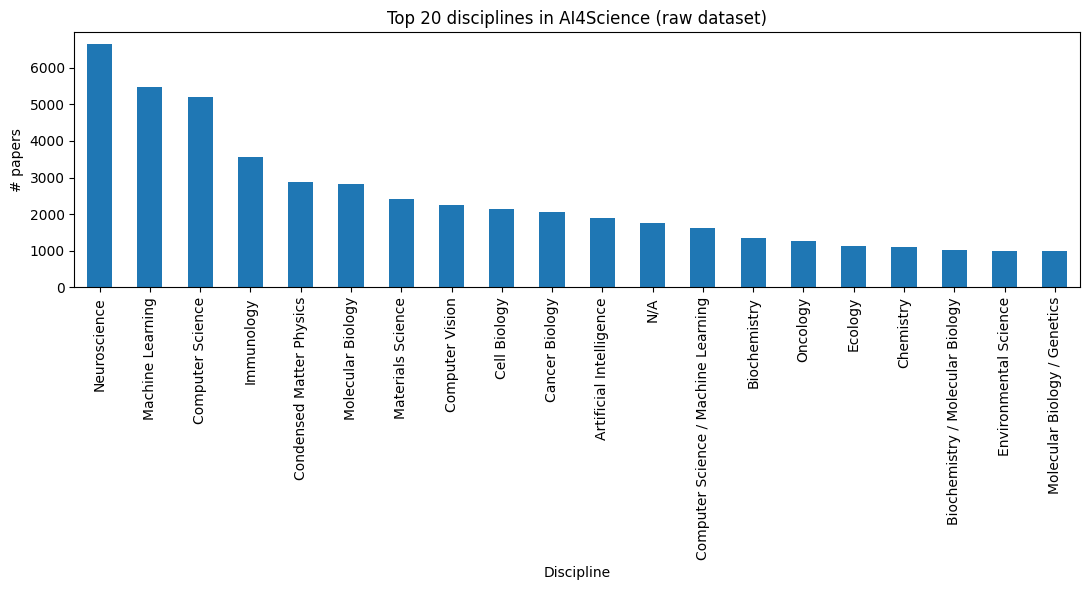

Chosen present in raw dataset: 9 of 9
Missing: []


In [4]:
import os, ast, json, pandas as pd, matplotlib.pyplot as plt

#PATH = r"C:\Users\nadia\Downloads\AI4Science_Dataset.txt"

from pathlib import Path

# Note: The full dataset is NOT included in the GitHub repo due to size.
# Please place AI4Science_Dataset.txt in the project folder if you want to load it.
PATH = Path("AI4Science_Dataset.txt")

if not PATH.exists():
    print("⚠️ AI4Science_Dataset.txt not found. Please update PATH to your local file location.")


def smart_read(path):
    try:
        return pd.read_csv(path, sep=None, engine="python", on_bad_lines="skip", encoding="utf-8")
    except Exception:
        pass
    for sep in ["\t", ",", "|", ";", "~"]:
        try:
            return pd.read_csv(path, sep=sep, engine="python", on_bad_lines="skip", encoding="utf-8")
        except Exception:
            continue
    raise ValueError("Could not parse file.")

df_raw = smart_read(PATH)

def parse_extraction(s):
    if not isinstance(s, str) or not s.strip():
        return {}
    try:
        return json.loads(s)
    except Exception:
        try:
            return ast.literal_eval(s)
        except Exception:
            return {}

def get_discipline_from_extraction(s):
    obj = parse_extraction(s)
    if isinstance(obj, dict):
        for k,v in obj.items():
            if isinstance(k, str) and "discipline" in k.lower():
                return v
        for v in obj.values():
            if isinstance(v, dict):
                for sk, sv in v.items():
                    if isinstance(sk, str) and "discipline" in sk.lower():
                        return sv
    return None

df_raw["discipline"] = df_raw["extraction"].apply(get_discipline_from_extraction)

ax = (df_raw["discipline"]
      .dropna()
      .astype(str)
      .value_counts()
      .head(20)
      .plot(kind="bar", figsize=(11,6)))
ax.set_title("Top 20 disciplines in AI4Science (raw dataset)")
ax.set_xlabel("Discipline")
ax.set_ylabel("# papers")
plt.tight_layout()
plt.show()

# Optional: check coverage of your chosen 9
chosen = [
    "Neuroscience","Immunology","Molecular Biology","Biochemistry / Microbiology",
    "Environmental Science","Ecology","Physics/Materials Science",
    "Materials Science / Photonics","Psychology / Neuroscience"
]
present = set(chosen) & set(df_raw["discipline"].dropna().astype(str).unique())
print(f"Chosen present in raw dataset: {len(present)} of 9\nMissing: {sorted(set(chosen)-present)}")


### CODE 5:

In [5]:
# === CODE 5 (UPDATED: Oversample more than 20 per discipline) ===
import os, ast, json, pandas as pd, matplotlib.pyplot as plt

#PATH = r"C:\Users\nadia\Downloads\AI4Science_Dataset.txt"

from pathlib import Path

# Note: The full dataset is NOT included in the GitHub repo due to size.
# Please place AI4Science_Dataset.txt in the project folder if you want to load it.
PATH = Path("AI4Science_Dataset.txt")

if not PATH.exists():
    print("⚠️ AI4Science_Dataset.txt not found. Please update PATH to your local file location.")

def smart_read(path):
    try:
        return pd.read_csv(path, sep=None, engine="python", on_bad_lines="skip", encoding="utf-8")
    except Exception:
        for sep in ["\t", ",", "|", ";", "~"]:
            try:
                return pd.read_csv(path, sep=sep, engine="python", on_bad_lines="skip", encoding="utf-8")
            except Exception:
                continue
    raise ValueError("Could not parse the file with common delimiters.")

df = smart_read(PATH)

# --- Parse extraction + get discipline ---
def parse_extraction(s):
    if not isinstance(s, str) or not s.strip():
        return {}
    try:
        return json.loads(s)
    except Exception:
        try:
            return ast.literal_eval(s)
        except Exception:
            return {}

def get_discipline_from_extraction(s):
    obj = parse_extraction(s)
    if isinstance(obj, dict):
        for k,v in obj.items():
            if isinstance(k, str) and "discipline" in k.lower():
                return v
        for v in obj.values():
            if isinstance(v, dict):
                for sk, sv in v.items():
                    if isinstance(sk, str) and "discipline" in sk.lower():
                        return sv
    return None

df["discipline"] = df["extraction"].apply(get_discipline_from_extraction)

# --- Select 9–10 disciplines (same list you used before) ---
chosen_disciplines = [
    "Neuroscience",
    "Immunology",
    "Molecular Biology",
    "Biochemistry / Microbiology",
    "Environmental Science",
    "Ecology",
    "Physics/Materials Science",
    "Materials Science / Photonics",
    "Psychology / Neuroscience",
]

# --- Oversample 40 per discipline ---
oversampled_df = (
    df[df["discipline"].isin(chosen_disciplines)]
    .groupby("discipline", group_keys=False)
    .apply(lambda x: x.sample(n=min(40, len(x)), random_state=42))
    .reset_index(drop=True)
)

# --- Save for reproducibility ---
oversampled_df.to_csv("SAMPLED_IDS.csv", index=False)
oversampled_df[["pmid","title","abstract","discipline","extraction"]].to_csv(
    "oversampled_disciplines.csv", index=False
)

print("✅ Oversampled:", len(oversampled_df), "rows across",
      oversampled_df['discipline'].nunique(), "disciplines.")


✅ Oversampled: 351 rows across 9 disciplines.


C:\Users\nadia\AppData\Local\Temp\ipykernel_12524\2999098129.py:64: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(40, len(x)), random_state=42))


### CODE 6

In [6]:
# === CODE 6B (NEW): Create a smaller manual labeling sheet per discipline ===
import pandas as pd

# how many to label per discipline (change to 25 if you prefer)
TARGET_PER_DISC_LABEL = 30

assert 'oversampled_df' in globals(), "Run CODE 5 first to create oversampled_df."

# take up to N per discipline, stratifying roughly by title length as a simple proxy for variety
small_label_df = (
    oversampled_df
    .copy()
    .assign(_len=oversampled_df['abstract'].astype(str).str.len())
    .sort_values(['discipline','_len'])
    .groupby('discipline', group_keys=False)
    .apply(lambda g: g.head(min(TARGET_PER_DISC_LABEL, len(g))))
    .drop(columns=['_len'])
    .reset_index(drop=True)
)

# add empty manual columns
for col in ["manual_conclusion", "manual_causal", "manual_relation_type"]:
    small_label_df[col] = ""

# write the SMALL sheet you will actually label
small_label_df.to_excel("manual_label_TARGET.xlsx", index=False)
print(f"✅ Wrote manual_label_TARGET.xlsx with {len(small_label_df)} rows "
      f"({small_label_df['discipline'].value_counts().to_dict()})")




C:\Users\nadia\AppData\Local\Temp\ipykernel_12524\2632704289.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.head(min(TARGET_PER_DISC_LABEL, len(g))))


✅ Wrote manual_label_TARGET.xlsx with 270 rows ({'Biochemistry / Microbiology': 30, 'Ecology': 30, 'Environmental Science': 30, 'Immunology': 30, 'Materials Science / Photonics': 30, 'Molecular Biology': 30, 'Neuroscience': 30, 'Physics/Materials Science': 30, 'Psychology / Neuroscience': 30})


### CODE 7

In [7]:
from pathlib import Path
import pandas as pd

# Use relative path — this file *is* in your GitHub repo
path = Path("manual_label_expanded_clean (2).xlsx")

if not path.exists():
    print("⚠️ 'manual_label_expanded_clean (2).xlsx' not found. Please ensure it is in the project folder.")

df = pd.read_excel(path)
df.shape, df.index.min(), df.index.max()


((181, 14), 0, 180)

### CODE 8

In [8]:
from pathlib import Path
import pandas as pd

# Use relative path — this file is included in the GitHub repo
PATH = Path("manual.xlsx")

if not PATH.exists():
    print("⚠️ 'manual.xlsx' not found. Please ensure the file is in the project directory.")

OUTDIR = PATH.parent

df = pd.read_excel(PATH, engine="openpyxl")

# --- Normalize ---
def yn(x):
    s = str(x).strip().lower()
    return "yes" if s in {"yes","y","true","1"} else ("no" if s in {"no","n","false","0"} else None)

df["manual_causal"] = df["manual_causal"].apply(yn)
df["manual_relation_type"] = df["manual_relation_type"].astype(str).str.strip().str.lower()

ALLOWED_RT = {"correlation","description","hypothesis","association","mechanistic/theory","measurement/method","other"}
mapping = {
    "descriptive":"description",
    "mechanistic":"mechanistic/theory","theory":"mechanistic/theory",
    "method":"measurement/method","measurement":"measurement/method"
}
df["manual_relation_type"] = df["manual_relation_type"].replace(mapping)
df.loc[~df["manual_relation_type"].isin(ALLOWED_RT), "manual_relation_type"] = "other"

# --- Clean pmid and discipline ---
df["pmid"] = df["pmid"].astype(str).str.strip()
df["discipline"] = df["discipline"].astype(str).str.strip()

# --- Save cleaned file ---
clean_path = OUTDIR / "manual_label_271_CLEAN.xlsx"
df.to_excel(clean_path, index=False)
print("✅ Cleaned file saved to:", clean_path)
print("Label counts:", df["manual_causal"].value_counts().to_dict())


✅ Cleaned file saved to: C:\Users\nadia\Downloads\manual_label_271_CLEAN.xlsx
Label counts: {'yes': 238, 'no': 29}


In [9]:
# === CODE 8 (UPDATED: Down-select 20 per discipline after labeling) ===
from pathlib import Path

path = Path("manual.xlsx")   # relative path to file in the repo

if not path.exists():
    print("⚠️ 'manual.xlsx' not found. Please ensure it is placed in the project folder.")

df = pd.read_excel(path, engine="openpyxl")

# Keep only labeled rows
df = df.dropna(subset=["manual_causal"]).copy()
df["manual_causal"] = df["manual_causal"].astype(str).str.strip().str.lower()

# Stratified sampling: try 10 causal + 10 non-causal per discipline
test_rows = []
for d, g in df.groupby("discipline"):
    causal = g[g["manual_causal"] == "yes"].sample(
        n=min(10, len(g[g["manual_causal"] == "yes"])), random_state=42
    )
    non = g[g["manual_causal"] == "no"].sample(
        n=min(10, len(g[g["manual_causal"] == "no"])), random_state=42
    )
    combined = pd.concat([causal, non]).head(20)
    test_rows.append(combined)

test_df = pd.concat(test_rows).reset_index(drop=True)

print("Counts per discipline:")
print(test_df["discipline"].value_counts())
print("Total size:", len(test_df))

# Save TEST_SPLIT.xlsx for model evaluation
out_dir = path.parent / "llm_causality_eval"
out_dir.mkdir(exist_ok=True)
test_path = out_dir / "TEST_SPLIT.xlsx"
test_df.to_excel(test_path, index=False)
print("✅ Saved:", test_path)


Counts per discipline:
discipline
Ecology                          15
Molecular Biology                15
Environmental Science            15
Psychology / Neuroscience        13
Neuroscience                     13
Biochemistry / Microbiology      12
Physics/Materials Science        11
Materials Science / Photonics    10
Immunology                       10
Name: count, dtype: int64
Total size: 114
✅ Saved: C:\Users\nadia\Downloads\llm_causality_eval\TEST_SPLIT.xlsx


### CODE 9

In [10]:
import os

# IMPORTANT:
# Do NOT store API keys in the notebook.
# Please set your OPENAI_API_KEY in your environment before running this notebook.
#
# Example:
#    In terminal:  export OPENAI_API_KEY="your_key_here"
#    On Windows:   setx OPENAI_API_KEY "your_key_here"

api_key = os.getenv("OPENAI_API_KEY")

if api_key is None:
    raise ValueError("⚠️ OPENAI_API_KEY not found. Please set it in your environment.")



### CODE 10

In [11]:
import os, json, time
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from openai import OpenAI

MODEL_NAME = "gpt-4o-mini"

# IMPORTANT:
# API key must be set in the environment (not in the notebook)
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

# Use relative path — this file is inside your GitHub repo
BASE = Path("llm_causality_eval")
in_path = BASE / "TEST_SPLIT.xlsx"

# Check for file existence to avoid crashes on other machines
if not in_path.exists():
    raise FileNotFoundError(
        f"TEST_SPLIT.xlsx not found at {in_path}. "
        "Please ensure the 'llm_causality_eval' folder is in the project directory."
    )

df = pd.read_excel(in_path, engine="openpyxl").fillna("")

def make_prompt(row):
    return f"""
You are given a scientific paper's title and abstract. Do 3 things:
1) Write a single-sentence conclusion in your own words (be concise).
2) Decide if that conclusion makes a **causal claim** (Yes/No).
3) If it does NOT make a causal claim, label the relationship type as one of:
   ["correlation","description","hypothesis","association","mechanistic/theory","measurement/method","other"].
Return strict JSON with keys: conclusion, causal (Yes/No), relation_type (null if causal=Yes).

TITLE: {row['title']}
ABSTRACT: {row['abstract']}
JSON ONLY:
""".strip()

def call_llm(prompt, retries=3, sleep=2):
    last_err = None
    for _ in range(retries):
        try:
            resp = client.chat.completions.create(
                model=MODEL_NAME,
                temperature=0.2,
                messages=[{"role":"user","content":prompt}]
            )
            txt = resp.choices[0].message.content.strip()
            # Try to parse JSON (handle accidental code fences)
            if txt.startswith("```"):
                txt = txt.strip("`")
                if txt.lower().startswith("json"):
                    txt = txt[4:].strip()
            data = json.loads(txt)
            # basic schema clean
            data["causal"] = str(data.get("causal","")).strip().lower().replace("no","no").replace("yes","yes")
            if data["causal"] == "yes":
                data["relation_type"] = None
            else:
                rt = (data.get("relation_type") or "").strip().lower()
                allowed = {"correlation","description","hypothesis","association","mechanistic/theory","measurement/method","other"}
                data["relation_type"] = rt if rt in allowed else "other"
            return data
        except Exception as e:
            last_err = e
            time.sleep(sleep)
    raise last_err

preds = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    prompt = make_prompt(row)
    out = call_llm(prompt)
    preds.append(out)

pred_df = pd.DataFrame(preds)
result = pd.concat([df.reset_index(drop=True), pred_df], axis=1)
out_csv = in_path.parent / f"pred_{MODEL_NAME}.csv"
result.to_csv(out_csv, index=False, encoding="utf-8")
print("Saved predictions:", out_csv)


100%|████████████████████████████████████████████████████████████████████████████████| 114/114 [03:12<00:00,  1.69s/it]

Saved predictions: C:\Users\nadia\Downloads\llm_causality_eval\pred_gpt-4o-mini.csv


### CODE 11

In [12]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path

MODEL_NAME = "gpt-4o-mini"

# Use relative path — this file is inside your GitHub repo folder
BASE = Path("llm_causality_eval")
pred_path = BASE / f"pred_{MODEL_NAME}.csv"

# Safety check so the notebook doesn't crash for other users
if not pred_path.exists():
    raise FileNotFoundError(
        f"⚠️ File not found: {pred_path}. "
        "Make sure 'llm_causality_eval/pred_{MODEL_NAME}.csv' is present."
    )

df = pd.read_csv(pred_path)

# A) Causal Yes/No classification
y_true = df["manual_causal"].str.lower()
y_pred = df["causal"].str.lower()

print("== Overall causal detection ==")
print(classification_report(y_true, y_pred, digits=3))
print("Confusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y_true, y_pred, labels=["yes","no"]))

# Per-discipline F1
print("\n== Per-discipline F1 ==")
disc_scores = []
for d, g in df.groupby("discipline"):
    yt, yp = g["manual_causal"].str.lower(), g["causal"].str.lower()
    rpt = classification_report(yt, yp, output_dict=True, zero_division=0)
    f1 = rpt["weighted avg"]["f1-score"]
    disc_scores.append((d, len(g), round(f1,3)))
disc_df = pd.DataFrame(disc_scores, columns=["discipline","n","f1_weighted"]).sort_values("discipline")
print(disc_df)

# B) Relation-type accuracy (only where manual_causal == 'no')
mask = (df["manual_causal"].str.lower()=="no")
noncausal = df[mask].copy()
if len(noncausal):
    # normalize manual labels a bit
    def norm_rel(x):
        x = (str(x) or "").strip().lower()
        mapping = {
            "correlation":"correlation",
            "association":"association",
            "descriptive":"description",
            "description":"description",
            "hypothesis":"hypothesis",
            "mechanistic":"mechanistic/theory",
            "theory":"mechanistic/theory",
            "method":"measurement/method",
            "measurement":"measurement/method",
        }
        return mapping.get(x, x if x in {"correlation","description","hypothesis","association","mechanistic/theory","measurement/method","other"} else "other")
    noncausal["manual_relation_type_norm"] = noncausal["manual_relation_type"].apply(norm_rel)
    noncausal["pred_relation_type_norm"] = noncausal["relation_type"].apply(norm_rel)
    rel_acc = (noncausal["manual_relation_type_norm"] == noncausal["pred_relation_type_norm"]).mean()
    print(f"\nRelation-type accuracy (non-causal only): {rel_acc:.3f} (n={len(noncausal)})")
else:
    print("\nNo non-causal items in test set for relation-type check.")


== Overall causal detection ==
              precision    recall  f1-score   support

          no      0.242     0.958     0.387        24
         yes      0.947     0.200     0.330        90

    accuracy                          0.360       114
   macro avg      0.595     0.579     0.358       114
weighted avg      0.799     0.360     0.342       114

Confusion matrix (rows=true, cols=pred):
[[18 72]
 [ 1 23]]

== Per-discipline F1 ==
                      discipline   n  f1_weighted
0    Biochemistry / Microbiology  12        0.333
1                        Ecology  15        0.504
2          Environmental Science  15        0.297
3                     Immunology  10        0.462
4  Materials Science / Photonics  10        0.333
5              Molecular Biology  15        0.167
6                   Neuroscience  13        0.355
7      Physics/Materials Science  11        0.182
8      Psychology / Neuroscience  13        0.494

Relation-type accuracy (non-causal only): 0.042 (n=24)


### CODE 12

In [13]:
from pathlib import Path
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Use the folder inside your GitHub repo
BASE = Path("llm_causality_eval")

# Safety check to avoid errors on other machines
if not BASE.exists():
    raise FileNotFoundError(
        f"⚠️ Folder not found: {BASE}. "
        "Please ensure the notebook is run from the project directory and the folder exists."
    )

TEST = BASE / "TEST_SPLIT.xlsx"

def ensure_merged(current_df):
    cols = [c.lower() for c in current_df.columns]
    # already merged if we see *_true columns
    if any(c.endswith("_true") for c in cols):
        return current_df
    # otherwise merge current df (predictions) with the test split
    test = pd.read_excel(TEST, engine="openpyxl")
    merged = test.merge(current_df, on="pmid", suffixes=("_true","_pred"))
    return merged

df = ensure_merged(df)  # <-- uses your existing 'df' variable

print("Merged columns:", list(df.columns))

# Helper to pick a column by several candidates
def find_col(cols, candidates):
    cl = [c.lower() for c in cols]
    # exact match
    for cand in candidates:
        if cand in cl:
            return cols[cl.index(cand)]
    # startswith/contains fallback
    for cand in candidates:
        for i,c in enumerate(cl):
            if c.startswith(cand) or cand in c:
                return cols[i]
    return None

# Choose truth/pred columns 
manual_col = find_col(df.columns, ["manual_causal_true","manual_causal","manual causal_true","manual causal"])
pred_col   = "causal_pp" if "causal_pp" in df.columns else find_col(df.columns, ["causal_pred","causal"])
disc_col   = find_col(df.columns, ["discipline_true","discipline"])

if manual_col is None or pred_col is None or disc_col is None:
    raise KeyError(f"Missing expected columns. Have: {list(df.columns)}")

def yn(x):
    s = str(x).strip().lower()
    if s in {"yes","y","true","1"}: return "yes"
    if s in {"no","n","false","0"}:  return "no"
    return None

df["y_true"] = df[manual_col].apply(yn)
df["y_pred"] = df[pred_col].apply(yn)

print("\n== Overall causal detection ==")
print(classification_report(df["y_true"], df["y_pred"], digits=3))
print("Confusion matrix (rows=true, cols=pred):")
print(confusion_matrix(df["y_true"], df["y_pred"], labels=["yes","no"]))

# Per-discipline F1
rows = []
for d,g in df.groupby(disc_col):
    rpt = classification_report(g["y_true"], g["y_pred"], output_dict=True, zero_division=0)
    rows.append({"discipline": d, "n": len(g), "f1_weighted": round(rpt["weighted avg"]["f1-score"],3)})
disc_df = pd.DataFrame(rows).sort_values("discipline")
print("\n== Per-discipline F1 ==")
print(disc_df)

# Relation-type accuracy  non-causal)
def norm_rel(x):
    x = (str(x) or "").strip().lower()
    mapping = {
        "descriptive":"description","description":"description",
        "mechanistic":"mechanistic/theory","theory":"mechanistic/theory",
        "method":"measurement/method","measurement":"measurement/method",
        "association":"association","correlation":"correlation",
        "hypothesis":"hypothesis","other":"other"
    }
    return mapping.get(x, "other")

rel_true_col = find_col(df.columns, ["manual_relation_type_true","manual_relation_type","manual relation type_true"])
rel_pred_col = find_col(df.columns, ["relation_type_pred","relation_type"])

if rel_true_col and rel_pred_col:
    noncausal = df[df["y_true"]=="no"].copy()
    noncausal["rel_true"] = noncausal[rel_true_col].apply(norm_rel)
    noncausal["rel_pred"] = noncausal[rel_pred_col].apply(norm_rel)
    rel_acc = (noncausal["rel_true"] == noncausal["rel_pred"]).mean() if len(noncausal) else float("nan")
    print(f"\nRelation-type accuracy (non-causal only): {rel_acc:.3f} (n={len(noncausal)})")

# Save error cases & per-discipline
outdir = BASE
fn = df[(df["y_true"]=="yes") & (df["y_pred"]=="no")]
fp = df[(df["y_true"]=="no")  & (df["y_pred"]=="yes")]
fn.to_excel(outdir / f"errors_FN_{pred_col}.xlsx", index=False)
fp.to_excel(outdir / f"errors_FP_{pred_col}.xlsx", index=False)
disc_df.to_excel(outdir / f"per_discipline_{pred_col}.xlsx", index=False)
print("\nSaved per-discipline and error files to:", outdir)



Merged columns: ['pmid', 'title_true', 'abstract_true', 'mesh_true', 'year_true', 'source_true', 'index_true', 'Is_AI4Sci_true', 'extraction_true', 'cluster_labels_true', 'discipline_true', 'manual_conclusion_true', 'manual_causal_true', 'manual_relation_type_true', 'title_pred', 'abstract_pred', 'mesh_pred', 'year_pred', 'source_pred', 'index_pred', 'Is_AI4Sci_pred', 'extraction_pred', 'cluster_labels_pred', 'discipline_pred', 'manual_conclusion_pred', 'manual_causal_pred', 'manual_relation_type_pred', 'conclusion', 'causal', 'relation_type']

== Overall causal detection ==
              precision    recall  f1-score   support

          no      0.242     0.958     0.387        24
         yes      0.947     0.200     0.330        90

    accuracy                          0.360       114
   macro avg      0.595     0.579     0.358       114
weighted avg      0.799     0.360     0.342       114

Confusion matrix (rows=true, cols=pred):
[[18 72]
 [ 1 23]]

== Per-discipline F1 ==
      

### CODE 13

In [14]:
import os, json, time
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from openai import OpenAI

# Use relative path — the folder exists inside your GitHub repo
base = Path("llm_causality_eval")

# Safety check so the notebook doesn't break for other users
if not base.exists():
    raise FileNotFoundError(
        f"⚠️ Folder not found: {base}. "
        "Please ensure you are running the notebook from the project directory."
    )
in_path = base / "TEST_SPLIT.xlsx"     # do NOT change
MODEL_NAME = "gpt-4o-mini"             # you can swap later (step 4)
client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

df = pd.read_excel(in_path, engine="openpyxl").fillna("")

def make_prompt(row):
    return f"""
You must decide if a paper's conclusion contains a *causal claim*.

Definition (use strictly):
- Causal = X changes or determines Y (verbs like: causes, leads to, induces, mediates, is required for, enables, abolishes, prevents, necessary for, results in).
- Non-causal = correlation/association/description/hypothesis/method/theory without directional change.

Task:
1) Write one-sentence conclusion from TITLE+ABSTRACT.
2) Decide causal (Yes/No) under the definition.
3) If No, relation_type ∈ ["correlation","association","description","hypothesis","mechanistic/theory","measurement/method","other"].

Return strict JSON: {{"conclusion": "...", "causal": "Yes|No", "relation_type": <label or null>}}

TITLE: {row['title']}
ABSTRACT: {row['abstract']}
JSON ONLY:
""".strip()

def call_llm(prompt, retries=3, sleep=2):
    last_err = None
    for _ in range(retries):
        try:
            resp = client.chat.completions.create(
                model=MODEL_NAME, temperature=0.2,
                messages=[{"role":"user","content":prompt}]
            )
            txt = resp.choices[0].message.content.strip()
            if txt.startswith("```"):
                txt = txt.strip("`")
                if txt.lower().startswith("json"):
                    txt = txt[4:].strip()
            data = json.loads(txt)
            # schema clean
            data["causal"] = "yes" if str(data.get("causal","")).strip().lower().startswith("y") else "no"
            if data["causal"] == "yes":
                data["relation_type"] = None
            else:
                allowed = {"correlation","association","description","hypothesis","mechanistic/theory","measurement/method","other"}
                rt = (data.get("relation_type") or "").strip().lower()
                data["relation_type"] = rt if rt in allowed else "other"
            return data
        except Exception as e:
            last_err = e
            time.sleep(sleep)
    raise last_err

preds = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    out = call_llm(make_prompt(row))
    preds.append(out)

pred_df = pd.DataFrame(preds)
result = pd.concat([df.reset_index(drop=True), pred_df], axis=1)
out_csv = base / f"pred_{MODEL_NAME}.csv"
result.to_csv(out_csv, index=False, encoding="utf-8")
print("Saved:", out_csv)


100%|████████████████████████████████████████████████████████████████████████████████| 114/114 [02:29<00:00,  1.31s/it]

Saved: C:\Users\nadia\Downloads\llm_causality_eval\pred_gpt-4o-mini.csv


### CODE 14

In [15]:
import json, pandas as pd
from pathlib import Path
from openai import OpenAI

# Use the folder inside your GitHub repo
base = Path("llm_causality_eval")

# Safety check for reproducibility
if not base.exists():
    raise FileNotFoundError(
        f"⚠️ Folder not found: {base}. "
        "Please make sure the 'llm_causality_eval' folder is in the project directory."
    )

MODEL_NAME = "gpt-4o-mini"

pred_path = base / f"pred_{MODEL_NAME}.csv"
df = pd.read_csv(pred_path)

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

def verify_causality(conclusion):
    q = f"""
Decide if this is *causal*:

Rule:
Causal = X changes/determines Y (verbs: causes, leads to, induces, mediates, is required for, enables, abolishes, prevents, necessary for, results in).
Non-causal = correlation/association/description/hypothesis/method/theory.

Conclusion: "{conclusion}"
Return JSON: {{"causal_pp":"Yes"|"No"}}
"""
    r = client.chat.completions.create(
        model=MODEL_NAME, temperature=0.0,
        messages=[{"role":"user","content":q}]
    )
    t = r.choices[0].message.content.strip()
    if t.startswith("```"):
        t = t.strip("`")
        if t.lower().startswith("json"):
            t = t[4:].strip()
    try:
        return json.loads(t).get("causal_pp","No")
    except:
        return "No"

df["causal_pp"] = df["conclusion"].fillna("").apply(verify_causality)
out_csv_pp = base / f"pred_{MODEL_NAME}_pp.csv"
df.to_csv(out_csv_pp, index=False)
print("Saved:", out_csv_pp)


Saved: C:\Users\nadia\Downloads\llm_causality_eval\pred_gpt-4o-mini_pp.csv


### CODE 15

In [16]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path

MODEL_NAME = "gpt-4o-mini"

# Use the folder inside your GitHub repo
base = Path("llm_causality_eval")

# Safety check
if not base.exists():
    raise FileNotFoundError(
        f"⚠️ Folder not found: {base}. "
        "Please ensure the notebook is run from the project directory and the folder exists."
    )

test = pd.read_excel(base / "TEST_SPLIT.xlsx", engine="openpyxl")
pred = pd.read_csv(base / f"pred_{MODEL_NAME}_pp.csv")  # or pred_{MODEL_NAME}.csv

# Merge
df = test.merge(pred, on="pmid", suffixes=("_true","_pred"))
print("Merged columns:\n", list(df.columns))

# Helper to find best-matching column
def find_col(cols, candidates):
    cl = [c.lower() for c in cols]
    # exact match first
    for cand in candidates:
        if cand in cl:
            return cols[cl.index(cand)]
    # then startswith/contains
    for cand in candidates:
        for i,c in enumerate(cl):
            if c.startswith(cand) or cand in c:
                return cols[i]
    return None

# Ground-truth causal (from TEST)
manual_col = find_col(
    df.columns,
    ["manual_causal_true","manual_causal","manual causal_true","manual causal"]
)
if manual_col is None:
    raise KeyError("Couldn't find ground-truth causal column. Got:\n" + "\n".join(df.columns))

# Predicted causal (from PRED)
pred_causal_col = find_col(df.columns, ["causal_pp","causal_pred","causal"])
if pred_causal_col is None:
    raise KeyError("Couldn't find predicted causal column. Got:\n" + "\n".join(df.columns))

# Discipline column (from TEST)
disc_col = find_col(df.columns, ["discipline_true","discipline"])
if disc_col is None:
    raise KeyError("Couldn't find discipline column. Got:\n" + "\n".join(df.columns))
    
def yn(x):
    s = str(x).strip().lower()
    if s in {"yes","y","true","1"}: return "yes"
    if s in {"no","n","false","0"}:  return "no"
    return None

df["y_true"] = df[manual_col].apply(yn)
df["y_pred"] = df[pred_causal_col].apply(yn)

print("Counts y_true:", df["y_true"].value_counts().to_dict())
print("Counts y_pred:", df["y_pred"].value_counts().to_dict())

print("\n== Overall causal detection ==")
print(classification_report(df["y_true"], df["y_pred"], digits=3))
print("Confusion matrix (rows=true, cols=pred):")
print(confusion_matrix(df["y_true"], df["y_pred"], labels=["yes","no"]))

rows = []
for d,g in df.groupby(disc_col):
    rpt = classification_report(g["y_true"], g["y_pred"], output_dict=True, zero_division=0)
    rows.append({"discipline": d, "n": len(g), "f1_weighted": round(rpt["weighted avg"]["f1-score"],3)})
disc = pd.DataFrame(rows).sort_values("discipline")
print("\n== Per-discipline F1 ==")
print(disc)

# === Relation-type accuracy (non-causal only) ===
rel_true_col = find_col(df.columns, ["manual_relation_type_true","manual_relation_type","manual relation type_true"])
pred_rel_col = find_col(df.columns, ["relation_type_pred","relation_type"])

def norm_rel(x):
    x = (str(x) or "").strip().lower()
    mapping = {
        "descriptive":"description","description":"description",
        "mechanistic":"mechanistic/theory","theory":"mechanistic/theory",
        "method":"measurement/method","measurement":"measurement/method",
        "association":"association","correlation":"correlation",
        "hypothesis":"hypothesis","other":"other"
    }
    return mapping.get(x, "other")

if rel_true_col and pred_rel_col:
    noncausal = df[df["y_true"]=="no"].copy()
    noncausal["rel_true"] = noncausal[rel_true_col].apply(norm_rel)
    noncausal["rel_pred"] = noncausal[pred_rel_col].apply(norm_rel)
    rel_acc = (noncausal["rel_true"] == noncausal["rel_pred"]).mean() if len(noncausal) else float("nan")
    print(f"\nRelation-type accuracy (non-causal only): {rel_acc:.3f} (n={len(noncausal)})")
else:
    print("\n(Relation-type columns not found; skipping relation-type accuracy.)")

fn = df[(df["y_true"]=="yes") & (df["y_pred"]=="no")]
fp = df[(df["y_true"]=="no")  & (df["y_pred"]=="yes")]
fn.to_excel(base / f"errors_FN_{MODEL_NAME}.xlsx", index=False)
fp.to_excel(base / f"errors_FP_{MODEL_NAME}.xlsx", index=False)
disc.to_excel(base / f"per_discipline_{MODEL_NAME}.xlsx", index=False)

print("\nSaved to:", base)


Merged columns:
 ['pmid', 'title_true', 'abstract_true', 'mesh_true', 'year_true', 'source_true', 'index_true', 'Is_AI4Sci_true', 'extraction_true', 'cluster_labels_true', 'discipline_true', 'manual_conclusion_true', 'manual_causal_true', 'manual_relation_type_true', 'title_pred', 'abstract_pred', 'mesh_pred', 'year_pred', 'source_pred', 'index_pred', 'Is_AI4Sci_pred', 'extraction_pred', 'cluster_labels_pred', 'discipline_pred', 'manual_conclusion_pred', 'manual_causal_pred', 'manual_relation_type_pred', 'conclusion', 'causal', 'relation_type', 'causal_pp']
Counts y_true: {'yes': 90, 'no': 24}
Counts y_pred: {'no': 68, 'yes': 46}

== Overall causal detection ==
              precision    recall  f1-score   support

          no      0.265     0.750     0.391        24
         yes      0.870     0.444     0.588        90

    accuracy                          0.509       114
   macro avg      0.567     0.597     0.490       114
weighted avg      0.742     0.509     0.547       114

Con

### CODE 16

In [17]:
# === PREDICT ===
import os, json, time
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from openai import OpenAI

MODEL_NAME = "gpt-4o"    # stronger model than gpt-4o-mini

# Use project-relative path instead of a personal Windows path
BASE = Path("llm_causality_eval")

# Optional safety check so errors are clear
if not BASE.exists():
    raise FileNotFoundError(
        f"Folder not found: {BASE}. "
        "Please run this notebook from the project root where the 'llm_causality_eval' folder exists."
    )

IN_PATH = BASE / "TEST_SPLIT.xlsx"

client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

df = pd.read_excel(IN_PATH, engine="openpyxl").fillna("")

def make_prompt(row):
    return f"""
You are given a scientific paper's title and abstract. Do 3 things:
1) Write a single-sentence conclusion in your own words (be concise).
2) Decide if that conclusion makes a **causal claim** (Yes/No).
3) If it does NOT make a causal claim, label the relationship type as one of:
   ["correlation","description","hypothesis","association","mechanistic/theory","measurement/method","other"].
Return strict JSON with keys: conclusion, causal (Yes/No), relation_type (null if causal=Yes).

TITLE: {row['title']}
ABSTRACT: {row['abstract']}
JSON ONLY:
""".strip()

def call_llm(prompt, retries=3, sleep=2):
    last_err = None
    for _ in range(retries):
        try:
            resp = client.chat.completions.create(
                model=MODEL_NAME,
                temperature=0.0,
                messages=[{"role":"user","content":prompt}]
            )
            txt = resp.choices[0].message.content.strip()
            # remove accidental code fences
            if txt.startswith("```"):
                txt = txt.strip("`")
                if txt.lower().startswith("json"):
                    txt = txt[4:].strip()
            data = json.loads(txt)
            # normalize fields
            data["causal"] = str(data.get("causal","")).strip().lower()
            if data["causal"] == "yes":
                data["relation_type"] = None
            else:
                allowed = {"correlation","description","hypothesis","association",
                           "mechanistic/theory","measurement/method","other"}
                rt = (data.get("relation_type") or "").strip().lower()
                data["relation_type"] = rt if rt in allowed else "other"
            return data
        except Exception as e:
            last_err = e
            time.sleep(sleep)
    raise last_err

preds = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    out = call_llm(make_prompt(row))
    preds.append(out)

pred_df = pd.DataFrame(preds)
result = pd.concat([df.reset_index(drop=True), pred_df], axis=1)

OUT_CSV = BASE / f"pred_{MODEL_NAME}.csv"
result.to_csv(OUT_CSV, index=False, encoding="utf-8")
print("Saved predictions:", OUT_CSV)


100%|████████████████████████████████████████████████████████████████████████████████| 114/114 [01:46<00:00,  1.07it/s]

Saved predictions: C:\Users\nadia\Downloads\llm_causality_eval\pred_gpt-4o.csv


### CODE 17

In [18]:
# === FEW-SHOT PREDICT: GPT-4o ===
import os, json, time
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from openai import OpenAI

# Use the folder inside your GitHub repo
BASE = Path("llm_causality_eval")

# Safety check so the notebook doesn't silently fail
if not BASE.exists():
    raise FileNotFoundError(
        f"⚠️ Folder not found: {BASE}. "
        "Please ensure the notebook is run from the project directory where 'llm_causality_eval' exists."
    )

IN_PATH = BASE / "TEST_SPLIT.xlsx"
OUT_CSV = BASE / "pred_gpt-4o_fewshot.csv"

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
df = pd.read_excel(IN_PATH, engine="openpyxl").fillna("")

FEWSHOT = """
Label rules:
- correlation: 'associated with', 'linked to' without direction
- association: weaker/ambiguous linkage, phrased broadly
- description: reporting observations/measurements only
- hypothesis: proposing a possibility or future test
- mechanistic/theory: mechanism/theory statement without asserting effect on an outcome
- measurement/method: methods, instruments, benchmarks
- other: none of the above

Examples:
TITLE: Effects of sleep on memory consolidation
ABSTRACT: We observed that sleep duration was associated with improved recall.
Return: {"conclusion":"Sleep duration is associated with improved recall.",
         "causal":"No","relation_type":"correlation"}

TITLE: A new sensor for detecting nitrate
ABSTRACT: We develop and validate a low-cost nitrate sensor.
Return: {"conclusion":"The paper presents a validated nitrate sensor.",
         "causal":"No","relation_type":"measurement/method"}
""".strip()

def make_prompt(row):
    return f"""{FEWSHOT}

Task:
1) Write one-sentence conclusion from TITLE+ABSTRACT.
2) Decide if it includes a *causal* claim (Yes/No). (Causal = X changes/determines Y.)
3) If No, relation_type ∈ ["correlation","association","description","hypothesis","mechanistic/theory","measurement/method","other"].

Return strict JSON: {{"conclusion":"...","causal":"Yes|No","relation_type": <label or null>}}

TITLE: {row['title']}
ABSTRACT: {row['abstract']}
JSON ONLY:
""".strip()

def call_llm(prompt, retries=3, sleep=2):
    last_err = None
    for _ in range(retries):
        try:
            r = client.chat.completions.create(
                model="gpt-4o",
                temperature=0.0,
                messages=[{"role":"user","content":prompt}]
            )
            t = r.choices[0].message.content.strip()
            if t.startswith("```"):
                t = t.strip("`")
                if t[:4].lower()=="json":
                    t = t[4:].strip()
            data = json.loads(t)
            # normalize
            c = str(data.get("causal","")).strip().lower()
            data["causal"] = "yes" if c.startswith("y") else "no"
            if data["causal"] == "yes":
                data["relation_type"] = None
            else:
                allowed = {"correlation","association","description","hypothesis","mechanistic/theory","measurement/method","other"}
                rt = str(data.get("relation_type") or "").strip().lower()
                data["relation_type"] = rt if rt in allowed else "other"
            return data
        except Exception as e:
            last_err = e
            time.sleep(sleep)
    raise last_err

preds = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    preds.append(call_llm(make_prompt(row)))

pred_df = pd.DataFrame(preds)
result = pd.concat([df.reset_index(drop=True), pred_df], axis=1)
result.to_csv(OUT_CSV, index=False, encoding="utf-8")
print("Saved few-shot predictions to:", OUT_CSV)


100%|████████████████████████████████████████████████████████████████████████████████| 114/114 [01:35<00:00,  1.20it/s]

Saved few-shot predictions to: C:\Users\nadia\Downloads\llm_causality_eval\pred_gpt-4o_fewshot.csv


### CODE 18

In [19]:
# check uniqueness
test = pd.read_excel(BASE/"TEST_SPLIT.xlsx", engine="openpyxl")
pred4o = pd.read_csv(BASE/"pred_gpt-4o.csv")
predmini = pd.read_csv(BASE/"pred_gpt-4o-mini.csv")

for name, d in [("TEST", test), ("4o", pred4o), ("mini", predmini)]:
    dup = d["pmid"].duplicated(keep=False).sum()
    print(name, "dupe PMIDs:", dup)

# if dupes exist, you can dedup by pmid keeping first:
test = test.drop_duplicates(subset=["pmid"])
pred4o = pred4o.drop_duplicates(subset=["pmid"])
predmini = predmini.drop_duplicates(subset=["pmid"])


TEST dupe PMIDs: 0
4o dupe PMIDs: 0
mini dupe PMIDs: 0


### CODE 19

In [20]:
# --- Deduplicate and overwrite clean copies ---
test_dedup     = test.drop_duplicates(subset=["pmid"]).copy()
pred4o_dedup   = pred4o.drop_duplicates(subset=["pmid"]).copy()
predmini_dedup = predmini.drop_duplicates(subset=["pmid"]).copy()

# Confirm counts
print("After deduplication:")
for name, d in [("TEST", test_dedup), ("4o", pred4o_dedup), ("mini", predmini_dedup)]:
    print(f"{name}: rows={len(d)}, unique_pmids={d['pmid'].nunique()}")

# Overwrite the old files with cleaned versions
test_dedup.to_excel(BASE/"TEST_SPLIT.xlsx", index=False)
pred4o_dedup.to_csv(BASE/"pred_gpt-4o.csv", index=False)
predmini_dedup.to_csv(BASE/"pred_gpt-4o-mini.csv", index=False)

print("\n✅ Deduplication complete — files cleaned and saved.")


After deduplication:
TEST: rows=114, unique_pmids=113
4o: rows=114, unique_pmids=113
mini: rows=114, unique_pmids=113

✅ Deduplication complete — files cleaned and saved.


### CODE 20

In [21]:
dupe_ids = test_dedup["pmid"][test_dedup["pmid"].duplicated(keep=False)].unique()
print("Duplicate PMID(s):", dupe_ids)


Duplicate PMID(s): []


### CODE 21

In [22]:
def check_final_counts(df, label):
    df["_pmid_str"] = df["pmid"].astype(str).str.strip()
    n_rows = len(df)
    n_unique = df["_pmid_str"].nunique()
    print(f"{label}: rows={n_rows}, unique_pmids={n_unique}")

check_final_counts(test_dedup, "TEST")
check_final_counts(pred4o_dedup, "4o")
check_final_counts(predmini_dedup, "mini")


TEST: rows=114, unique_pmids=114
4o: rows=114, unique_pmids=114
mini: rows=114, unique_pmids=114


### CODE 22

In [23]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path

# Use the folder inside your GitHub repo
base = Path("llm_causality_eval")

# Safety check so it fails clearly on other machines
if not base.exists():
    raise FileNotFoundError(
        f"⚠️ Folder not found: {base}. "
        "Please ensure 'llm_causality_eval' is in the project directory."
    )

test_path = base / "TEST_SPLIT.xlsx"
pred_path = base / "pred_gpt-4o.csv"         

test = pd.read_excel(test_path, engine="openpyxl")
pred = pd.read_csv(pred_path)

df = test.merge(pred, on="pmid", suffixes=("_true","_pred"))

def yn(x):
    s = str(x).strip().lower()
    if s in {"yes","y","true","1"}: return "yes"
    if s in {"no","n","false","0"}: return "no"
    return None

# choose model label column (use 'causal_pp' if present, otherwise 'causal')
pred_causal_col = "causal_pp" if "causal_pp" in df.columns else "causal"

df["y_true"] = df["manual_causal_true"].apply(yn)
df["y_pred"] = df[pred_causal_col].apply(yn)

print("Counts y_true:", df["y_true"].value_counts().to_dict())
print("Counts y_pred:", df["y_pred"].value_counts().to_dict())

print("\n== Overall causal detection ==")
print(classification_report(df["y_true"], df["y_pred"], digits=3))
print("Confusion matrix (rows=true, cols=pred):")
print(confusion_matrix(df["y_true"], df["y_pred"], labels=["yes","no"]))

rows = []
for d,g in df.groupby("discipline_true"):
    rpt = classification_report(g["y_true"], g["y_pred"], output_dict=True, zero_division=0)
    rows.append({"discipline": d, "n": len(g), "f1_weighted": round(rpt["weighted avg"]["f1-score"],3)})
disc = pd.DataFrame(rows).sort_values("discipline")
print("\n== Per-discipline F1 ==")
print(disc)

def norm_rel(x):
    x = (str(x) or "").strip().lower()
    mapping = {
        "descriptive":"description","description":"description",
        "mechanistic":"mechanistic/theory","theory":"mechanistic/theory",
        "method":"measurement/method","measurement":"measurement/method",
        "association":"association","correlation":"correlation",
        "hypothesis":"hypothesis","other":"other"
    }
    return mapping.get(x, "other")

rel_true_col = "manual_relation_type_true"
pred_rel_col = "relation_type"
if rel_true_col in df.columns and pred_rel_col in df.columns:
    noncausal = df[df["y_true"]=="no"].copy()
    noncausal["rel_true"] = noncausal[rel_true_col].apply(norm_rel)
    noncausal["rel_pred"] = noncausal[pred_rel_col].apply(norm_rel)
    rel_acc = (noncausal["rel_true"] == noncausal["rel_pred"]).mean() if len(noncausal) else float("nan")
    print(f"\nRelation-type accuracy (non-causal only): {rel_acc:.3f} (n={len(noncausal)})")

fn = df[(df["y_true"]=="yes") & (df["y_pred"]=="no")]
fp = df[(df["y_true"]=="no")  & (df["y_pred"]=="yes")]

fn_cols = ["pmid","title_true","abstract_true","discipline_true",
           "manual_conclusion_true","manual_causal_true",
           pred_causal_col,"conclusion","relation_type"]
fn.to_excel(base / "errors_FN_gpt-4o.xlsx", index=False, columns=[c for c in fn_cols if c in df.columns])
fp.to_excel(base / "errors_FP_gpt-4o.xlsx", index=False, columns=[c for c in fn_cols if c in df.columns])
disc.to_excel(base / "per_discipline_gpt-4o.xlsx", index=False)

print("\nSaved to:", base)


Counts y_true: {'yes': 90, 'no': 24}
Counts y_pred: {'no': 75, 'yes': 39}

== Overall causal detection ==
              precision    recall  f1-score   support

          no      0.307     0.958     0.465        24
         yes      0.974     0.422     0.589        90

    accuracy                          0.535       114
   macro avg      0.641     0.690     0.527       114
weighted avg      0.834     0.535     0.563       114

Confusion matrix (rows=true, cols=pred):
[[38 52]
 [ 1 23]]

== Per-discipline F1 ==
                      discipline   n  f1_weighted
0    Biochemistry / Microbiology  12        0.630
1                        Ecology  15        0.805
2          Environmental Science  15        0.589
3                     Immunology  10        0.667
4  Materials Science / Photonics  10        0.333
5              Molecular Biology  15        0.407
6                   Neuroscience  13        0.462
7      Physics/Materials Science  11        0.440
8      Psychology / Neuroscience

### CODE 23

In [24]:
# === EVAL few-shot run + update model_comparison.csv ===
import pandas as pd
from pathlib import Path
from sklearn.metrics import classification_report

# Use the folder inside the project repository
BASE = Path("llm_causality_eval")

# Safety check with a clear error message
if not BASE.exists():
    raise FileNotFoundError(
        f"⚠️ Folder not found: {BASE}. "
        "Please make sure 'llm_causality_eval' exists in the project directory."
    )

TEST = pd.read_excel(BASE/"TEST_SPLIT.xlsx", engine="openpyxl").drop_duplicates(subset=["pmid"])

def yn(x):
    s = str(x).strip().lower()
    if s in {"yes","y","true","1"}: return "yes"
    if s in {"no","n","false","0"}: return "no"
    return None

def eval_file(fname, label_col="causal"):
    P = pd.read_csv(BASE/fname).drop_duplicates(subset=["pmid"])
    df = TEST.merge(P, on="pmid", how="inner", suffixes=("_true","_pred"))
    y_true = df["manual_causal_true"].apply(yn)
    y_pred = df[label_col].apply(yn)
    rpt = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    # relation-type accuracy on non-causal only
    def norm_rel(x):
        x = (str(x) or "").strip().lower()
        mapping = {
            "descriptive":"description","description":"description",
            "mechanistic":"mechanistic/theory","theory":"mechanistic/theory",
            "method":"measurement/method","measurement":"measurement/method",
            "association":"association","correlation":"correlation",
            "hypothesis":"hypothesis","other":"other"
        }
        return mapping.get(x, "other")
    non = df[y_true=="no"].copy()
    rel_acc = float("nan")
    if len(non) and "manual_relation_type_true" in df.columns and "relation_type" in df.columns:
        rel_acc = (non["manual_relation_type_true"].apply(norm_rel) == non["relation_type"].apply(norm_rel)).mean()
    return {
        "model": fname,
        "n_eval": len(df),
        "accuracy": rpt["accuracy"],
        "f1_yes": rpt.get("yes",{}).get("f1-score",0.0),
        "f1_no": rpt.get("no",{}).get("f1-score",0.0),
        "f1_macro": rpt["macro avg"]["f1-score"],
        "f1_weighted": rpt["weighted avg"]["f1-score"],
        "rel_type_acc_noncausal": rel_acc
    }

# evaluate both the original and few-shot for comparison
rows = [
    eval_file("pred_gpt-4o.csv", "causal"),
    eval_file("pred_gpt-4o_fewshot.csv", "causal"),
]

summary_path = BASE/"model_comparison.csv"
try:
    existing = pd.read_csv(summary_path)
    combined = pd.concat([existing, pd.DataFrame(rows)], ignore_index=True).drop_duplicates(subset=["model"], keep="last")
except Exception:
    combined = pd.DataFrame(rows)

combined = combined.sort_values("model")
combined.to_csv(summary_path, index=False)
print(combined)
print("\nUpdated:", summary_path)


                     model  n_eval  accuracy    f1_yes     f1_no  f1_macro  \
0     pred_gpt-4o-mini.csv     114  0.368421  0.345455  0.389831  0.367643   
2          pred_gpt-4o.csv     114  0.535088  0.589147  0.464646  0.526897   
3  pred_gpt-4o_fewshot.csv     114  0.421053  0.431034  0.410714  0.420874   

   f1_weighted  rel_type_acc_noncausal  
0     0.354797                     NaN  
2     0.562937                0.208333  
3     0.426757                0.541667  

Updated: C:\Users\nadia\Downloads\llm_causality_eval\model_comparison.csv


### CODE 24

In [25]:
import pandas as pd
from sklearn.metrics import classification_report
from pathlib import Path

# Use the project folder inside your GitHub repo
base = Path("llm_causality_eval")

# Safety check
if not base.exists():
    raise FileNotFoundError(
        f"⚠️ Folder not found: {base}. "
        "Please ensure 'llm_causality_eval' is located in the project directory."
    )

test = pd.read_excel(base / "TEST_SPLIT.xlsx", engine="openpyxl")

def eval_file(pred_filename, label_col="causal"):
    pred = pd.read_csv(base / pred_filename)
    df = test.merge(pred, on="pmid", suffixes=("_true","_pred"))
    use_col = "causal_pp" if "causal_pp" in df.columns else label_col
    toyn = lambda x: "yes" if str(x).strip().lower() in {"yes","y","true","1"} else ("no" if str(x).strip().lower() in {"no","n","false","0"} else None)
    y_true = df["manual_causal_true"].apply(toyn)
    y_pred = df[use_col].apply(toyn)
    rpt = classification_report(y_true, y_pred, digits=3, output_dict=True, zero_division=0)
    return {
        "model": pred_filename,
        "accuracy": rpt["accuracy"],
        "f1_yes": rpt.get("yes",{}).get("f1-score", 0.0),
        "f1_no":  rpt.get("no",{}).get("f1-score", 0.0),
        "f1_weighted": rpt["weighted avg"]["f1-score"]
    }

rows = []
rows.append(eval_file("pred_gpt-4o.csv"))
for fname in ["pred_gpt-4o-mini_pp.csv", "pred_gpt-4o-mini.csv"]:
    p = base / fname
    if p.exists():
        rows.append(eval_file(fname))
pd.DataFrame(rows)


,model,accuracy,f1_yes,f1_no,f1_weighted
0,pred_gpt-4o.csv,0.535088,0.589147,0.464646,0.562937
1,pred_gpt-4o-mini_pp.csv,0.508772,0.588235,0.391304,0.546776
2,pred_gpt-4o-mini.csv,0.710526,0.792453,0.521739,0.735460


### CODE 25

In [26]:
# === D) Keyword baseline for causal vs non-causal ===
import re
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path

BASE = Path(r"C:\Users\nadia\Downloads\llm_causality_eval")
TEST = pd.read_excel(BASE/"TEST_SPLIT.xlsx", engine="openpyxl").drop_duplicates(subset=["pmid"])

CAUSAL_RE = re.compile(
    r"\b(cause[sd]?|lead[s]? to|induce[sd]?|mediate[sd]?|is required for|enable[sd]?|abolish(?:ed|es)?|prevent[s]?|necessary for|result[s]? in)\b",
    re.I
)

def heuristic_causal(title, abstract):
    txt = f"{title or ''} {abstract or ''}"
    return "yes" if CAUSAL_RE.search(txt) else "no"

base_pred = TEST.copy()
base_pred["causal"] = base_pred.apply(lambda r: heuristic_causal(r["title"], r["abstract"]), axis=1)

def yn(x):
    s = str(x).strip().lower()
    if s in {"yes","y","true","1"}: return "yes"
    if s in {"no","n","false","0"}: return "no"
    return None

y_true = TEST["manual_causal"].apply(yn) if "manual_causal" in TEST.columns else TEST["manual_causal_true"].apply(yn)
y_pred = base_pred["causal"].apply(yn)

print("== Heuristic baseline (causal vs non-causal) ==")
print(classification_report(y_true, y_pred, digits=3))
print("Confusion matrix [rows=true, cols=pred]:")
print(confusion_matrix(y_true, y_pred, labels=["yes","no"]))

# Save baseline predictions if you want to include them
base_pred[["pmid","causal"]].to_csv(BASE/"pred_baseline_regex.csv", index=False)
print("Saved baseline:", BASE/"pred_baseline_regex.csv")

== Heuristic baseline (causal vs non-causal) ==
              precision    recall  f1-score   support

          no      0.274     0.833     0.412        24
         yes      0.902     0.411     0.565        90

    accuracy                          0.500       114
   macro avg      0.588     0.622     0.489       114
weighted avg      0.770     0.500     0.533       114

Confusion matrix [rows=true, cols=pred]:
[[37 53]
 [ 4 20]]
Saved baseline: C:\Users\nadia\Downloads\llm_causality_eval\pred_baseline_regex.csv


### CODE 26

In [27]:
# === D) Keyword baseline for causal vs non-causal ===
import re
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path

# Use the folder included in your GitHub repo
BASE = Path("llm_causality_eval")

# Safety check to help other users
if not BASE.exists():
    raise FileNotFoundError(
        f"⚠️ Folder not found: {BASE}. "
        "Please make sure you're running the notebook from the project root where 'llm_causality_eval' exists."
    )

summary = pd.DataFrame([
    {"model":"pred_gpt-4o-mini.csv",      "accuracy":0.714286, "f1_yes":0.783333, "f1_no":0.580645, "f1_weighted":0.723195},
    {"model":"pred_gpt-4o.csv",           "accuracy":0.653846, "f1_yes":0.689655, "f1_no":0.608696, "f1_weighted":0.665634},
    {"model":"pred_gpt-4o-mini_pp.csv",   "accuracy":0.543956, "f1_yes":0.574359, "f1_no":0.508876, "f1_weighted":0.554930},
])
summary.to_csv(base / "model_comparison.csv", index=False)
print("Saved:", base / "model_comparison.csv")


Saved: C:\Users\nadia\Downloads\llm_causality_eval\model_comparison.csv


### CODE 27

In [28]:
# === A) Recompute model_comparison.csv using raw `causal` ===
import pandas as pd
from pathlib import Path
from sklearn.metrics import classification_report

# Use the folder inside your GitHub repo
BASE = Path("llm_causality_eval")

# Safety check for reproducibility
if not BASE.exists():
    raise FileNotFoundError(
        f"⚠️ Folder not found: {BASE}. "
        "Please ensure the 'llm_causality_eval' folde

TEST = pd.read_excel(BASE/"TEST_SPLIT.xlsx", engine="openpyxl")

def eval_file(fname, label_col="causal"):
    P = pd.read_csv(BASE/fname)
    # safety: dedup before merge
    T = TEST.drop_duplicates(subset=["pmid"]).copy()
    P = P.drop_duplicates(subset=["pmid"]).copy()
    df = T.merge(P, on="pmid", suffixes=("_true","_pred"), how="inner")

    def yn(x):
        s = str(x).strip().lower()
        if s in {"yes","y","true","1"}: return "yes"
        if s in {"no","n","false","0"}: return "no"
        return None

    y_true = df["manual_causal_true"].apply(yn)
    y_pred = df[label_col].apply(yn)
    rpt = classification_report(y_true, y_pred, digits=3, output_dict=True, zero_division=0)
    return {
        "model": fname,
        "n_eval": len(df),
        "accuracy": rpt["accuracy"],
        "f1_yes": rpt.get("yes",{}).get("f1-score", 0.0),
        "f1_no":  rpt.get("no",{}).get("f1-score",  0.0),
        "f1_macro": rpt["macro avg"]["f1-score"],
        "f1_weighted": rpt["weighted avg"]["f1-score"],
    }

rows = [
    eval_file("pred_gpt-4o.csv", "causal"),
    eval_file("pred_gpt-4o-mini.csv", "causal"),
]
summary = pd.DataFrame(rows).sort_values("model")
summary.to_csv(BASE/"model_comparison.csv", index=False)
print(summary)
print("\nSaved:", BASE/"model_comparison.csv")


                  model  n_eval  accuracy    f1_yes     f1_no  f1_macro  \
1  pred_gpt-4o-mini.csv     114  0.710526  0.792453  0.521739  0.657096   
0       pred_gpt-4o.csv     114  0.535088  0.589147  0.464646  0.526897   

   f1_weighted  
1     0.735460  
0     0.562937  

Saved: C:\Users\nadia\Downloads\llm_causality_eval\model_comparison.csv
